In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from yahoo_historical import Fetcher


#from statsmodels.tsa.api import ExponentialSmoothing
#from pmdarima.arima import auto_arima


In [2]:
ticker = 'QQQ'
start = [2018,12,31]

df = Fetcher(ticker, start).getHistorical()	
#df = df[['Date','Close']]
df.Date = pd.to_datetime(df.Date)
print(df.shape)
df.head()

(439, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-12-31,154.470001,154.979996,152.710007,154.259995,152.389069,53015300
1,2019-01-02,150.990005,155.750000,150.880005,154.880005,153.001556,58576700
2,2019-01-03,152.600006,153.259995,149.490005,149.820007,148.002945,74820200
3,2019-01-04,152.339996,157.000000,151.740005,156.229996,154.335175,74709300
4,2019-01-07,156.619995,158.860001,156.110001,158.089996,156.172623,52059300


In [3]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
434,2020-09-21,262.470001,267.649994,260.109985,267.510010,267.510010,57168600
435,2020-09-22,269.989990,273.079987,266.540009,272.480011,272.480011,41128900
436,2020-09-23,272.149994,272.339996,263.250000,264.160004,264.160004,48837300
437,2020-09-24,261.390015,268.700012,261.220001,265.390015,265.390015,70631700
438,2020-09-25,265.910004,272.399994,264.299988,271.559998,271.559998,55186000


In [4]:
train = df.iloc[:-30, [0,4]].reset_index(drop=True)
test = df.iloc[-30:,[0,4]].reset_index(drop=True)
print(train.shape)
print(test.shape)

(409, 2)
(30, 2)


In [5]:
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [6]:
n_steps_in = 6
n_steps_out = 1


In [7]:
type(train)

pandas.core.frame.DataFrame

In [8]:
train.tail(10)

,Date,Close
399,2020-07-31,265.790009
400,2020-08-03,269.380005
401,2020-08-04,270.380005
402,2020-08-05,271.049988
403,2020-08-06,274.640015
404,2020-08-07,271.470001
405,2020-08-10,270.309998
406,2020-08-11,265.190002
407,2020-08-12,271.859985
408,2020-08-13,272.480011


In [9]:
tr = train.Close.to_frame()[:-n_steps_in]

In [10]:
tr.shape

(403, 1)

In [35]:
tr

,Close
0,154.259995
1,154.880005
2,149.820007
3,156.229996
4,158.089996
...,...
398,261.130005
399,265.790009
400,269.380005
401,270.380005


In [34]:
train.iloc[402,:]

Date     2020-08-05 00:00:00
Close                 271.05
Name: 402, dtype: object

In [11]:
n_features = tr.shape[1]
n_features

1

In [12]:
X, y = split_sequences(np.array(tr), n_steps_in, n_steps_out)

In [13]:
X.shape

(397, 6, 1)

In [14]:
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')

In [15]:
model.fit(X, y, epochs=300, verbose=0)

In [16]:
te = test.Close.to_frame()

In [17]:
trail = train.Close.to_frame()[-n_steps_in:]
trail

,Close
403,274.640015
404,271.470001
405,270.309998
406,265.190002
407,271.859985
408,272.480011


In [18]:
train.tail()

,Date,Close
404,2020-08-07,271.470001
405,2020-08-10,270.309998
406,2020-08-11,265.190002
407,2020-08-12,271.859985
408,2020-08-13,272.480011


In [19]:
te = pd.concat([trail,te], axis=0)

In [24]:
#te

In [25]:
df[df.Date>=pd.to_datetime('2019-10-4')].head()

,Date,Open,High,Low,Close,Adj Close,Volume
192,2019-10-04,187.080002,189.080002,186.880005,188.809998,187.650269,31887600
193,2019-10-07,188.270004,189.740005,187.910004,188.240005,187.083786,21216000
194,2019-10-08,187.059998,187.860001,185.270004,185.419998,184.281097,32379300
195,2019-10-09,186.990005,188.080002,186.429993,187.229996,186.079987,20147400
196,2019-10-10,187.279999,189.429993,187.119995,188.679993,187.521072,25177700


In [26]:
te.shape

(36, 1)

In [27]:
X_in,_ = split_sequences(np.array(te), n_steps_in, n_steps_out)

In [28]:
print(X_in.shape)

(30, 6, 1)


In [29]:
pred = np.zeros(X_in.shape[0])
for i in range(X_in.shape[0]):
    X_in1 = X_in[i].reshape((1, n_steps_in, n_features))
    pred[i] = model.predict(X_in1)


In [30]:
pred.shape

(30,)

In [31]:
test['pred'] = pred

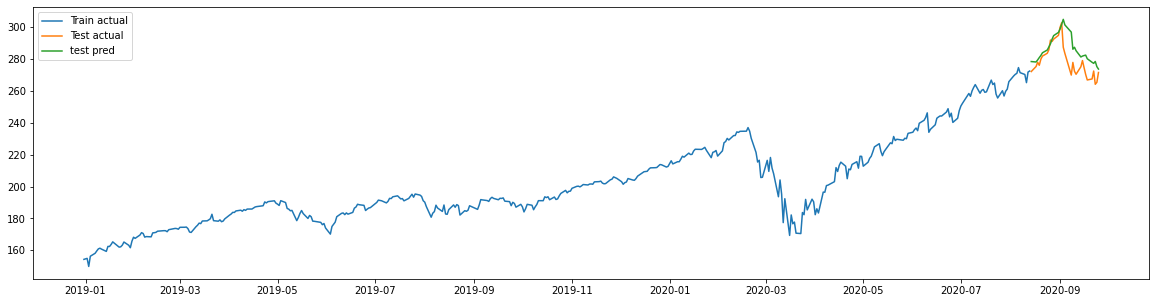

In [32]:
plt.figure(figsize=(20,5))
plt.plot(train.Date, train.Close)
plt.plot(test.Date, test.Close)
plt.plot(test.Date, test.pred)
plt.legend(['Train actual','Test actual','test pred'])

In [36]:
test.head()

,Date,Close,pred
0,2020-08-14,272.160004,278.430450
1,2020-08-17,275.320007,278.154388
2,2020-08-18,277.970001,279.464294
3,2020-08-19,276.100006,280.926300
4,2020-08-20,279.929993,282.257782


In [37]:
test['dir'] = test.Close.diff()
test['dir_pred'] = test.pred-test.Close.shift(1)
test['dir_bin'] = test.dir>0
test['dir_bin'] = test.dir_bin.astype(int)
test['dir_pred_bin'] = test.dir_pred>0
test.dir_pred_bin = test.dir_pred_bin.astype(int)
test.head()

,Date,Close,pred,dir,dir_pred,dir_bin,dir_pred_bin
0,2020-08-14,272.160004,278.430450,NaN,NaN,0,0
1,2020-08-17,275.320007,278.154388,3.160003,5.994384,1,1
2,2020-08-18,277.970001,279.464294,2.649994,4.144287,1,1
3,2020-08-19,276.100006,280.926300,-1.869995,2.956299,0,1
4,2020-08-20,279.929993,282.257782,3.829987,6.157776,1,1


In [38]:
test['match'] = test.dir_bin==test.dir_pred_bin
test.match.sum()/test.shape[0]

0.6333333333333333